# HES1 Michaelis-Menten toy model

The [HES1MODEL](http://pints.readthedocs.io/en/latest/toy/hes1_michaelis_menten.html) describes the expression level of the transcription factor Hes1, details of the model see [here](https://doi.org/10.1038/ncomms1496).

The model has 3 state variables $m$, $p_1$ and $p_2$, where $m$ represents the molecular concentrations of Hes1 mRNA, and $p_1, p_2$ represent the molecular concentrations of cytoplasmic and nuclear proteins, respectively.
It is described by the ODE:

$$      \frac{dm}{dt} = -k_{deg}m + \frac{1}{1 + (p_2/P_0)^h} \\
        \frac{dp_1}{dt} = -k_{deg} p_1 + \nu m - k_1 p_1 \\
        \frac{dp_2}{dt} = -k_{deg} p_2 + k_1 p_1  $$

where $k_1$ is the rate of transport of Hes1 protein into the nucleus; $P_0$ is the amount of Hes1 protein in the nucleus, when the rate of transcription of Hes1 mRNA is at half its maximal value; $\nu$ is the rate of translation of Hes1 mRNA, and $h$ is the Hill coefficient. They are the model parameters to be inferred; whereas $k_{deg}$ is the Hes1 protein degradation rate which is assumed to be known. 

In this model, only the state variable $m$ is an observable, i.e. can be observed in the experiments. The input order of parameters of interest is $\{ P_0, \nu, k_1, h \}$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pints
import pints.toy

model = pints.toy.HES1Model()

print('Outputs: ' + str(model.n_outputs()))
print('Parameters: ' + str(model.n_parameters()))

Outputs: 1
Parameters: 4


We can get some suggested parameters and plot some data! In experiments, typically it is not easy to have high sampling rate (time points), so our suggested time points match what is feasible to see in actual experiments. However, it is also good to have a look at what the model does by giving it a higher sampling rate (time points).

[ 2.4    0.025  0.11   6.9  ]


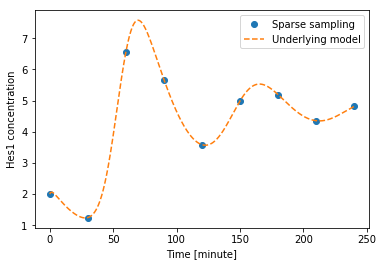

In [2]:
times = model.suggested_times()
smooth_times = np.linspace(times[0], times[-1], 1000)
parameters = model.suggested_parameters()
print(parameters)

plt.figure()
plt.xlabel('Time [minute]')
plt.ylabel('Hes1 concentration')
plt.plot(times, model.simulate(parameters, times), 'o', label='Sparse sampling')
plt.plot(smooth_times, model.simulate(parameters, smooth_times), '--', label='Underlying model')
plt.legend()
plt.show()

In this set-up, we only see one of the state variables representing the Hes1 concentration. However, it is also interesting to see the dynamics of the whole system (i.e. by inspecting all state variables). This can be done by `simulate_all_states(parameters, times)` provided in this model.

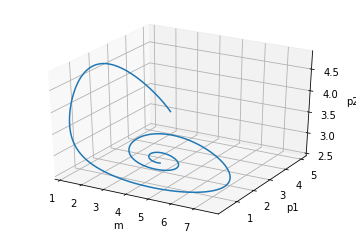

In [3]:
all_states = model.simulate_all_states(parameters, smooth_times)

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('m')
ax.set_ylabel('p1')
ax.set_zlabel('p2')
plt.plot(all_states[:, 0], all_states[:, 1], all_states[:, 2])
plt.show()

We can explore the model further by varying the initial conditions:

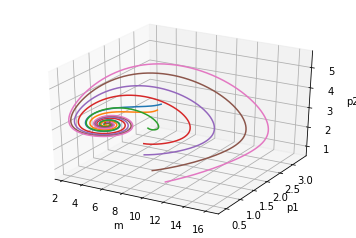

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('m')
ax.set_ylabel('p1')
ax.set_zlabel('p2')

suggested_init = model.initial_conditions()
suggested_hidden_param = np.array(model.implicit_parameters())
for x in [1.5, 1.6, 2, 2.5, 3, 4, 5]:
    model.set_initial_conditions(suggested_init * x)
    model.set_implicit_parameters(list(suggested_hidden_param[0:-1] / x) + [suggested_hidden_param[-1]])
    all_states = model.simulate_all_states(parameters, smooth_times)
    plt.plot(all_states[:, 0], all_states[:, 1], all_states[:, 2])
plt.show()

# Reset initial conditions
model.set_initial_conditions(suggested_init)
model.set_implicit_parameters(suggested_hidden_param)

Then by varying the parameters:

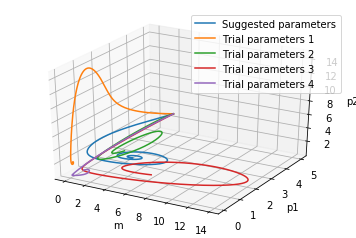

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('m')
ax.set_ylabel('p1')
ax.set_zlabel('p2')

# Try some different parameter sets {P0, v, k1, h}
Try_params = [[0.5, 0.5, 0.6, 4.0],
              [0.5, 0.1, 0.01, 5.5],
              [0.4, 0.01, 0.01, 6.0],
              [0.05, 0.05, 0.01, 7.0]]

# Compare with suggested parameters
all_states = model.simulate_all_states(parameters, smooth_times)
plt.plot(all_states[:, 0], all_states[:, 1], all_states[:, 2], label='Suggested parameters')
for i, try_param in enumerate(Try_params):
    all_states = model.simulate_all_states(try_param, smooth_times)
    plt.plot(all_states[:, 0], all_states[:, 1], all_states[:, 2], label='Trial parameters %d'%(i+1))
plt.legend()
plt.show()

We can then try to set up and run a MCMC routine with suggested values which origianlly obtained from real experimental results (taken from [1]):

[1] Silk, D. et al. Designing attractive models via automated identification of chaotic and oscillatory dynamical regimes. Nat. Commun. 2:489 doi: 10.1038/ncomms1496 (2011).

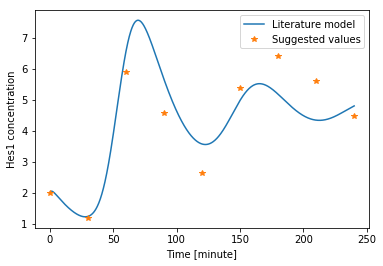

In [6]:
# Get suggested values
values = model.suggested_values()

plt.figure()
plt.xlabel('Time [minute]')
plt.ylabel('Hes1 concentration')
plt.plot(smooth_times, model.simulate(parameters, smooth_times), label='Literature model')
plt.plot(times, values, '*', label='Suggested values')
plt.legend()
plt.show()

In [7]:
# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a log posterior
log_prior = pints.UniformLogPrior(list(parameters * 0.1) + [0.1], 
                                  list(parameters * 10) + [5])
log_likelihood = pints.UnknownNoiseLogLikelihood(problem)
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Run MCMC on the noisy data
x0 = [list(parameters*1.2) + [0.5]]*3
mcmc = pints.MCMCSampling(log_posterior, 3, x0)
mcmc.set_max_iterations(10000)
# mcmc.set_log_to_screen(False)

print('Running')
chains = mcmc.run()
print('Done!')

Running
Using Adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     6      0         0         0          0:00.0
2     9      0         0         0.333      0:00.0
3     12     0.25      0         0.25       0:00.0
20    63     0.0952    0.19      0.143      0:00.1
40    123    0.0488    0.0976    0.0732     0:00.3
60    183    0.0328    0.0984    0.082      0:00.4
80    243    0.0494    0.0864    0.0864     0:00.6
100   303    0.0495    0.0891    0.0693     0:00.7
120   363    0.0579    0.0992    0.0826     0:00.8
140   423    0.0567    0.0922    0.0922     0:00.9
160   483    0.0621    0.087     0.087      0:01.1
180   543    0.0718    0.0939    0.0939     0:01.2
200   603    0.0647    0.0995    0.0995     0:01.3
220   663    0.0995    0.149     0.145      0:01.5
240   723    0.158     0.174     0.178      0:01.6
260   783    0.183908  0.195     0.188      0

3100  9303   0.254     0.262     0.261      0:31.7
3120  9363   0.257     0.262     0.261      0:32.0
3140  9423   0.258     0.262     0.26       0:32.3
3160  9483   0.259     0.263     0.26       0:32.6
3180  9543   0.258     0.262     0.261553   0:32.9
3200  9603   0.259294  0.260856  0.260856   0:33.1
3220  9663   0.261099  0.26      0.26       0:33.4
3240  9723   0.261     0.26      0.259      0:33.7
3260  9783   0.262     0.26      0.258203   0:34.0
3280  9843   0.26242   0.26      0.259      0:34.2
3300  9903   0.264     0.26      0.259      0:34.5
3320  9963   0.266     0.258657  0.257      0:34.8
3340  10023  0.265     0.257     0.257408   0:35.1
3360  10083  0.265     0.256     0.259      0:35.4
3380  10143  0.266     0.255     0.26       0:35.7
3400  10203  0.265     0.254337  0.261      0:36.0
3420  10263  0.266     0.253727  0.261      0:36.3
3440  10323  0.269     0.253     0.26068    0:36.5
3460  10383  0.27      0.252     0.259      0:36.9
3480  10443  0.268     0.25079 

6320  18963  0.277     0.284     0.276      1:33.5
6340  19023  0.278     0.284     0.277      1:33.9
6360  19083  0.278     0.283     0.277      1:34.3
6380  19143  0.278     0.283     0.276      1:34.7
6400  19203  0.278     0.282     0.277      1:35.1
6420  19263  0.278     0.282     0.276281   1:35.4
6440  19323  0.279     0.282     0.276      1:35.8
6460  19383  0.28      0.282     0.276      1:36.2
6480  19443  0.28      0.282     0.276      1:36.6
6500  19503  0.28      0.281     0.275      1:37.0
6520  19563  0.279405  0.281     0.275      1:37.4
6540  19623  0.279     0.282     0.275      1:37.8
6560  19683  0.279     0.282     0.275      1:38.2
6580  19743  0.278985  0.283     0.276      1:38.5
6600  19803  0.279     0.282     0.276      1:38.9
6620  19863  0.279263  0.283     0.276      1:39.3
6640  19923  0.28      0.282     0.276      1:39.7
6660  19983  0.28      0.282     0.275334   1:40.0
6680  20043  0.281     0.282     0.275      1:40.4
6700  20103  0.281     0.283   

9540  28623  0.287     0.284     0.283      2:38.1
9560  28683  0.287     0.284     0.283      2:38.5
9580  28743  0.286     0.284     0.284      2:38.9
9600  28803  0.286     0.284     0.283408   2:39.2
9620  28863  0.286     0.284     0.284      2:39.7
9640  28923  0.285     0.284     0.284      2:40.1
9660  28983  0.285     0.284     0.283511   2:40.6
9680  29043  0.284     0.283     0.283      2:41.0
9700  29103  0.284     0.283     0.283      2:41.4
9720  29163  0.284     0.282687  0.283      2:41.8
9740  29223  0.284     0.283     0.283      2:42.1
9760  29283  0.284     0.282     0.283      2:42.5
9780  29343  0.285     0.282     0.282      2:42.9
9800  29403  0.284     0.283     0.282      2:43.3
9820  29463  0.285     0.283     0.282      2:43.7
9840  29523  0.285     0.283     0.282      2:44.1
9860  29583  0.285     0.283     0.282      2:44.5
9880  29643  0.286     0.283     0.281      2:44.8
9900  29703  0.286     0.284     0.281      2:45.2
9920  29763  0.285     0.283   

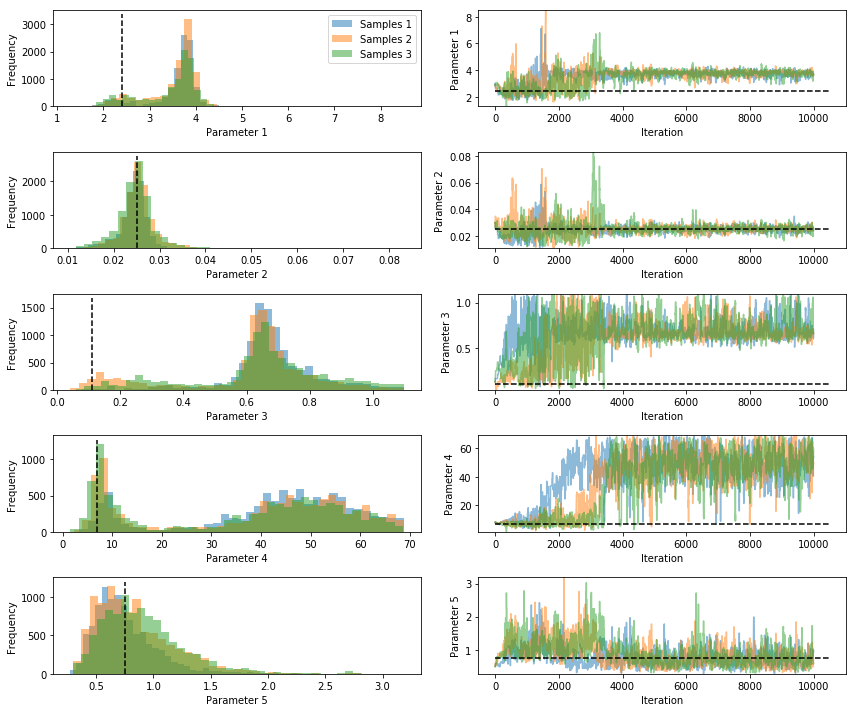

In [8]:
import pints.plot
pints.plot.trace(chains, ref_parameters=list(parameters)+[0.75])
plt.show()

We can also compare the predictions with these values to what we found:

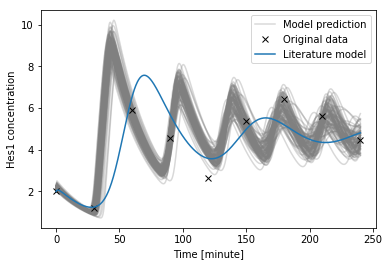

In [9]:
# Select first chain
chain1 = chains[0]

# Remove burn-in
chain1 = chain1[7500:]

# Plot some predictions with these samples
plt.figure()
plt.xlabel('Time [minute]')
plt.ylabel('Hes1 concentration')
for posterior_param in chain1[::25]:
    model_prediction = model.simulate(posterior_param[:-1], smooth_times)
    plt.plot(smooth_times, model_prediction, c='Gray', alpha=0.3)
plt.plot(smooth_times, model_prediction, c='Gray', alpha=0.3, label='Model prediction')
plt.plot(times, values, 'kx', label='Original data')
plt.plot(smooth_times, model.simulate(parameters, smooth_times), label='Literature model')
plt.legend()
plt.show()

This is interesting, as this might show that with the sparse sampling points, we cannot retreive the same dynamical behaviour as the literature model. As it is obvious that (can be seen by eyes!) our model predictions from the MCMC posterior give a closer alignment (hence smaller 'error') to the data points. This could be due to several factors, one of which could be the uninformative prior that we used, and that failed to constraint the parameters in a good biologically/physically justifiable parameter region. 